In [ ]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import softmax
import multiprocessing as mp
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.nn import functional as F
from sklearn.preprocessing import normalize

# Installing ProdLDA
**Restart notbook after the installation!!**

In [ ]:
!git clone https://github.com/estebandito22/PyTorchAVITM

Cloning into 'PyTorchAVITM'...
remote: Enumerating objects: 19052, done.
remote: Total 19052 (delta 0), reused 0 (delta 0), pack-reused 19052
Receiving objects: 100% (19052/19052), 132.62 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (37/37), done.


# 1. Creation of synthetic corpus

We consider a scenario with n parties, each of them as an associated corpus.
To generate the corpus associated with each of the parties, we consider a common beta distribution (word-topic distribution), but we freeze different topics/ assign different asymmetric Dirichlet priors favoring different topics at the time of generating the document that composes each party's corpus.

## 1.1. Function for permuting the Dirichlet prior at each node

In [ ]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

## 1.2. Topic modeling and node settings

In [ ]:
# Topic modeling settings
vocab_size = 1000
n_topics = 10
beta = 1
alpha = 5/n_topics
n_docs = 1000
nwords = (150, 450) #Min and max lengths of the documents

# Nodes settings
n_nodes = 5
frozen_topics = 3
dirichlet_symmetric = False
prior = (n_topics)*[0.4]
prior[0] = prior[1] = prior[2] = 0.1
print(prior)

[0.1, 0.1, 0.1, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]


## 1.3. Topics generation (common for all nodes)

In [ ]:
topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
print('Ordered probabilities for the first topic vector:')
print(np.sort(topic_vectors[0])[::-1])
print(topic_vectors.shape)

Ordered probabilities for the first topic vector:
[1.00462614e-02 7.32736572e-03 6.36683414e-03 6.28109133e-03
 6.09683089e-03 5.09364935e-03 5.09216451e-03 5.00001130e-03
 4.88863195e-03 4.81524397e-03 4.69130198e-03 4.60975629e-03
 4.60940861e-03 4.59727407e-03 4.59346375e-03 4.16128897e-03
 4.08170614e-03 4.05354888e-03 3.87123967e-03 3.81795332e-03
 3.77493566e-03 3.62689555e-03 3.61005626e-03 3.60913327e-03
 3.56100173e-03 3.50657564e-03 3.48969217e-03 3.48069216e-03
 3.43835628e-03 3.40208399e-03 3.38384436e-03 3.38221910e-03
 3.32680615e-03 3.31788723e-03 3.31039883e-03 3.26466910e-03
 3.24123239e-03 3.17337306e-03 3.16658779e-03 3.15605661e-03
 3.12685700e-03 3.12291232e-03 3.09627376e-03 3.06502122e-03
 3.05497566e-03 3.05476927e-03 3.02287323e-03 3.00993296e-03
 2.99795531e-03 2.99305525e-03 2.98096753e-03 2.97499598e-03
 2.96830849e-03 2.96585455e-03 2.92160597e-03 2.91671342e-03
 2.91009636e-03 2.87627049e-03 2.87059317e-03 2.86544155e-03
 2.83889360e-03 2.80270139e-03 2.79

## 1.4. Generation of document topic proportions and documents for each node


In [ ]:
doc_topics_all_gt = []
documents_all = []
z_all = []
for i in np.arange(n_nodes):
  # Step 2 - generation of document topic proportions for each node
  if dirichlet_symmetric:
    doc_topics = np.random.dirichlet((n_topics)*[alpha], n_docs)
  else:
    doc_topics = np.random.dirichlet(prior, n_docs)
    prior = rotateArray(prior, len(prior), 3)
    print(prior)
  print('Ordered probabilities for the first document - node', str(i), ':')
  print(np.sort(doc_topics[0])[::-1])
  doc_topics_all_gt.append(doc_topics)
  # Step 3 - Document generation
  documents = [] # Document words
  z = [] # Assignments
  for docid in np.arange(n_docs):
      doc_len = np.random.randint(low=nwords[0], high=nwords[1])
      this_doc_words = []
      this_doc_assigns = []
      for wd_idx in np.arange(doc_len):
          tpc = np.nonzero(np.random.multinomial(1, doc_topics[docid]))[0][0]
          this_doc_assigns.append(tpc)
          word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
          this_doc_words.append('wd'+str(word))
      z.append(this_doc_assigns)
      documents.append(this_doc_words)
  print("Documents of node", str(i), "generated.")
  documents_all.append(documents)
  z_all.append(z)

[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.1, 0.1, 0.1]
Ordered probabilities for the first document - node 0 :
[6.88093512e-01 1.55049334e-01 1.32865778e-01 1.62185249e-02
 5.27018340e-03 1.89921823e-03 6.01371601e-04 1.64877332e-06
 3.20370275e-07 1.07712654e-07]
Documents of node 0 generated.
[0.4, 0.4, 0.4, 0.4, 0.1, 0.1, 0.1, 0.4, 0.4, 0.4]
Ordered probabilities for the first document - node 1 :
[5.20347037e-01 2.05038567e-01 9.38538270e-02 9.22610957e-02
 7.57159714e-02 1.27592388e-02 1.72284307e-05 6.60350584e-06
 3.79878786e-07 5.17564305e-08]
Documents of node 1 generated.
[0.4, 0.1, 0.1, 0.1, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
Ordered probabilities for the first document - node 2 :
[3.32058559e-01 3.01604401e-01 2.15284878e-01 6.66583376e-02
 3.57576345e-02 3.50658961e-02 9.66453040e-03 2.21992216e-03
 1.67616446e-03 9.67668291e-06]
Documents of node 2 generated.
[0.1, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.1, 0.1]
Ordered probabilities for the first document - node 3 :
[4.74085598e-01 1

# 2. Preprocessing, generation of training dataset and training of a ProdLDA model at each node

In [ ]:
ls

PyTorchAVITM/  sample_data/


In [ ]:
cd /content/PyTorchAVITM/pytorchavitm/datasets

/content/PyTorchAVITM/pytorchavitm/datasets


In [ ]:
from bow import BOWDataset

In [ ]:
cd /content/PyTorchAVITM

/content/PyTorchAVITM


In [ ]:
from pytorchavitm import AVITM

In [ ]:
train_datasets = []
avitms = []
id2tokens = []
for corpus_node in documents_all:
  cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
  docs = [" ".join(corpus_node[i]) for i in np.arange(len(corpus_node))]

  train_bow = cv.fit_transform(docs)
  train_bow = train_bow.toarray()

  idx2token = cv.get_feature_names()
  input_size = len(idx2token)

  id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
  id2tokens.append(id2token)

  train_data = BOWDataset(train_bow, idx2token)

  avitm = AVITM(input_size=input_size, n_components=10, model_type='prodLDA',
                hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
                learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
                solver='adam', num_epochs=100, reduce_on_plateau=False)

  avitm.fit(train_data)
  avitms.append(avitm)

  train_datasets.append(train_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None
Epoch: [1/100]	Samples: [1000/100000]	Train Loss: 2182.83503125	Time: 0:00:00.422205
Epoch: [2/100]	Samples: [2000/100000]	Train Loss: 2163.7754453125	Time: 0:00:00.210161
Epoch: [3/100]	Samples: [3000/100000]	Train Loss: 2153.888640625	Time: 0:00:00.211286
Epoch: [4/100]	Samples: [4000/100000]	Train Loss: 2148.2529453125	Time: 0:00:00.188458
Epoch: [5/100]	Samples: [5000/100000]	Train Loss: 2140.661875	Time: 0:00:00.192488
Epoch: [6/100]	Samples: [6000/100000]	Train Loss: 2137.066484375	Time: 0:00:00.210398
Epoch: [7/100]	Samples: [7000/100000]	Train Loss: 2129.3

# 2.1 Topics at each node

In [ ]:
topics_all = []
for node in np.arange(n_nodes):
  topics = pd.DataFrame(avitm.get_topics(10)).T
  topics_all.append(topics)
topics_all[0]

,0,1,2,3,4,5,6,7,8,9
0,wd677,wd575,wd655,wd878,wd442,wd123,wd486,wd918,wd705,wd199
1,wd67,wd691,wd725,wd219,wd455,wd66,wd653,wd396,wd476,wd183
2,wd725,wd622,wd544,wd447,wd34,wd183,wd990,wd425,wd57,wd354
3,wd203,wd515,wd148,wd513,wd279,wd74,wd491,wd215,wd847,wd856
4,wd265,wd84,wd396,wd326,wd942,wd607,wd66,wd784,wd673,wd988
5,wd0,wd899,wd183,wd790,wd691,wd560,wd612,wd244,wd810,wd824
6,wd82,wd948,wd27,wd131,wd640,wd764,wd812,wd509,wd327,wd18
7,wd871,wd381,wd628,wd456,wd174,wd205,wd595,wd937,wd212,wd706
8,wd810,wd186,wd163,wd6,wd659,wd316,wd668,wd537,wd99,wd323
9,wd236,wd61,wd394,wd761,wd562,wd770,wd287,wd887,wd525,wd506


## 2.2 Document-topic distributions at each node

In [ ]:
def get_doc_topic_distribution(avitm, dataset, n_samples=20):
    avitm.model.eval()

    loader = DataLoader(
            avitm.train_data, batch_size=avitm.batch_size, shuffle=True,
            num_workers=mp.cpu_count())

    pbar = tqdm(n_samples, position=0, leave=True)

    final_thetas = []
    for sample_index in range(n_samples):
        with torch.no_grad():
            collect_theta = []

            for batch_samples in loader:
                X = batch_samples['X']

                if avitm.USE_CUDA:
                  X = X.cuda()

                # forward pass
                avitm.model.zero_grad()
                
                with torch.no_grad():
                  posterior_mu, posterior_log_sigma = avitm.model.inf_net(X)

                  # Generate samples from theta
                  theta = F.softmax(
                          avitm.model.reparameterize(posterior_mu, posterior_log_sigma), dim=1)
                  theta = avitm.model.drop_theta(theta)

                collect_theta.extend(theta.cpu().numpy().tolist())

            pbar.update(1)
            pbar.set_description("Sampling: [{}/{}]".format(sample_index + 1, n_samples))

            final_thetas.append(np.array(collect_theta))
    pbar.close()
    return np.sum(final_thetas, axis=0) / n_samples

In [ ]:
doc_topic_all = []
for node in np.arange(n_nodes):
  doc_topic = get_doc_topic_distribution(avitms[node], train_datasets[node], n_samples=5) # get all the topic predictions
  print("Document-topic distribution node", str(node), "")
  doc_topic_all.append(doc_topic)
  print(np.array(doc_topics).shape)

Sampling: [5/5]: : 5it [00:00,  6.91it/s]


Document-topic distribution node 0 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.92it/s]


Document-topic distribution node 1 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.89it/s]


Document-topic distribution node 2 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  7.22it/s]


Document-topic distribution node 3 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  7.11it/s]

Document-topic distribution node 4 
(1000, 10)


## 2.3 Word-topic distributions attained at each node

In [ ]:
def get_topic_word_distribution(avtim_model):
  topic_word_matrix = avtim_model.model.beta.cpu().detach().numpy()
  return softmax(topic_word_matrix, axis=1)

In [ ]:
all_words = []
for word in np.arange(vocab_size+1):
  if word > 0:
    all_words.append('wd'+str(word))
print(all_words)

['wd1', 'wd2', 'wd3', 'wd4', 'wd5', 'wd6', 'wd7', 'wd8', 'wd9', 'wd10', 'wd11', 'wd12', 'wd13', 'wd14', 'wd15', 'wd16', 'wd17', 'wd18', 'wd19', 'wd20', 'wd21', 'wd22', 'wd23', 'wd24', 'wd25', 'wd26', 'wd27', 'wd28', 'wd29', 'wd30', 'wd31', 'wd32', 'wd33', 'wd34', 'wd35', 'wd36', 'wd37', 'wd38', 'wd39', 'wd40', 'wd41', 'wd42', 'wd43', 'wd44', 'wd45', 'wd46', 'wd47', 'wd48', 'wd49', 'wd50', 'wd51', 'wd52', 'wd53', 'wd54', 'wd55', 'wd56', 'wd57', 'wd58', 'wd59', 'wd60', 'wd61', 'wd62', 'wd63', 'wd64', 'wd65', 'wd66', 'wd67', 'wd68', 'wd69', 'wd70', 'wd71', 'wd72', 'wd73', 'wd74', 'wd75', 'wd76', 'wd77', 'wd78', 'wd79', 'wd80', 'wd81', 'wd82', 'wd83', 'wd84', 'wd85', 'wd86', 'wd87', 'wd88', 'wd89', 'wd90', 'wd91', 'wd92', 'wd93', 'wd94', 'wd95', 'wd96', 'wd97', 'wd98', 'wd99', 'wd100', 'wd101', 'wd102', 'wd103', 'wd104', 'wd105', 'wd106', 'wd107', 'wd108', 'wd109', 'wd110', 'wd111', 'wd112', 'wd113', 'wd114', 'wd115', 'wd116', 'wd117', 'wd118', 'wd119', 'wd120', 'wd121', 'wd122', 'wd123', 

In [ ]:
topic_word_all = []
for node in np.arange(n_nodes):
  w_t_distrib = np.zeros((10,vocab_size), dtype=np.float64) 
  wd = get_topic_word_distribution(avitms[node])
  for i in np.arange(10):
    for idx, word in id2tokens[node].items():
      for j in np.arange(len(all_words)):
        if all_words[j] == word:
          w_t_distrib[i,j] = wd[i][idx]
          break
  sum_of_rows = w_t_distrib.sum(axis=1)
  normalized_array = w_t_distrib / sum_of_rows[:, np.newaxis]
  topic_word_all.append(normalized_array)

# 3. Centralized model

In [ ]:
documents_centr = [*documents_all[0], *documents_all[1], *documents_all[2], *documents_all[3], *documents_all[4]]
len(documents_centr)

5000

In [ ]:
cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
docs_centr = [" ".join(documents_centr[i]) for i in np.arange(len(documents_centr))]

train_bow_centr = cv.fit_transform(docs_centr)
train_bow_centr = train_bow_centr.toarray()

idx2token_centr = cv.get_feature_names()
input_size_centr = len(idx2token_centr)

id2token_centr = {k: v for k, v in zip(range(0, len(idx2token_centr)), idx2token_centr)}

train_data_centr = BOWDataset(train_bow_centr, idx2token_centr)

avitm_centr = AVITM(input_size=input_size_centr, n_components=10, model_type='prodLDA',
              hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
              learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
              solver='adam', num_epochs=100, reduce_on_plateau=False)

avitm_centr.fit(train_data_centr)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [5000/500000]	Train Loss: 2168.373964453125	Time: 0:00:00.766800
Epoch: [2/100]	Samples: [10000/500000]	Train Loss: 2139.284569921875	Time: 0:00:00.789064
Epoch: [3/100]	Samples: [15000/500000]	Train Loss: 2119.59677265625	Time: 0:00:00.788946
Epoch: [4/100]	Samples: [20000/500000]	Train Loss: 2104.879643359375	Time: 0:00:00.777195
Epoch: [5/100]	Samples: [25000/500000]	Train Loss: 2089.17069296875	Time: 0:00:00.716656
Epoch: [6/100]	Samples: [30000/500000]	Train Loss: 2076.245284375	Time: 0:00:00.739070
Epoch: [7/100]	Samples: [35000/500000]	Train Loss: 2068.176354296875	Time: 0:00:00.781246
Epoch: [8/100]	Samples: [40000/500000]	Train Loss: 2063.36745703125	Time: 0:00:00.782577
Epoch: [9/100]	Samples: [45000/500000]	Train Loss: 2060.1215228515625	Time: 0:00:00.746390
Epoch: [10/100]	Samples: [50000/500000]	Train Loss: 2058.096546484375	Time: 0:00:00.759749
Epoch: [11/100]	Samples: [55000/500000]	Train Loss: 2056.7045859375	Time: 0:00:00.735178
Epoch: [12/100]	

In [ ]:
topics_centr = pd.DataFrame(avitm_centr.get_topics(10)).T
topics_centr

,0,1,2,3,4,5,6,7,8,9
0,wd184,wd683,wd408,wd917,wd97,wd48,wd673,wd745,wd303,wd35
1,wd148,wd255,wd515,wd491,wd71,wd203,wd856,wd839,wd847,wd235
2,wd186,wd659,wd668,wd790,wd810,wd632,wd6,wd163,wd475,wd89
3,wd812,wd509,wd948,wd327,wd834,wd27,wd640,wd183,wd131,wd577
4,wd182,wd815,wd988,wd875,wd523,wd704,wd197,wd460,wd953,wd692
5,wd371,wd991,wd203,wd436,wd395,wd311,wd199,wd151,wd892,wd746
6,wd677,wd575,wd655,wd878,wd763,wd979,wd442,wd199,wd486,wd618
7,wd386,wd907,wd382,wd543,wd154,wd215,wd764,wd605,wd866,wd588
8,wd770,wd236,wd525,wd671,wd394,wd61,wd761,wd59,wd522,wd670
9,wd307,wd724,wd619,wd667,wd837,wd278,wd926,wd373,wd7,wd332


In [ ]:
doc_topic_centr = get_doc_topic_distribution(avitm_centr, train_data_centr, n_samples=5) # get all the topic predictions
print(doc_topic_centr.shape)

Sampling: [5/5]: : 5it [00:01,  2.79it/s]

(5000, 10)


In [ ]:
w_t_distrib_centr = np.zeros((10,vocab_size), dtype=np.float64) # vocab_size = 10000
wd = get_topic_word_distribution(avitm_centr)
for i in np.arange(10):
  for idx, word in id2token_centr.items():
    for j in np.arange(len(all_words)):
      if all_words[j] == word:
        w_t_distrib_centr[i,j] = wd[i][idx]
        break
sum_of_rows = w_t_distrib_centr.sum(axis=1)
w_t_distrib_centr_norm = w_t_distrib_centr / sum_of_rows[:, np.newaxis]
print(w_t_distrib_centr_norm)
sum(w_t_distrib_centr_norm[8,:])

[[0.00100477 0.0010237  0.00102813 ... 0.00108335 0.00104689 0.        ]
 [0.00096004 0.00100935 0.00096311 ... 0.00091989 0.00094781 0.        ]
 [0.00094721 0.00098949 0.00101394 ... 0.00086728 0.00101072 0.        ]
 ...
 [0.00098012 0.00092885 0.00103538 ... 0.00080422 0.00097879 0.        ]
 [0.00113785 0.00109086 0.0010497  ... 0.00101823 0.0009678  0.        ]
 [0.00099336 0.00095731 0.00104003 ... 0.00106424 0.00110662 0.        ]]


0.9999999999999999

# 4. Get similarity through Frobenius

In [ ]:
doc_topic_centr_all = []
doc_topic_centr_all.append(doc_topic_centr[0:1000,:])
doc_topic_centr_all.append(doc_topic_centr[1000:2000,:])
doc_topic_centr_all.append(doc_topic_centr[2000:3000,:])
doc_topic_centr_all.append(doc_topic_centr[3000:4000,:])
doc_topic_centr_all.append(doc_topic_centr[4000:5000,:])

In [ ]:
for node in np.arange(n_nodes):
  # Ground truth in node vs inferred in node
  doc_topics_avitm_sqrt_node = np.sqrt(doc_topic_all[node])
  similarity_avitm_node = doc_topics_avitm_sqrt_node.dot(doc_topics_avitm_sqrt_node.T)

  doc_topics_gt_sqrt_node = np.sqrt(doc_topics_all_gt[node])
  similarity_gt = doc_topics_gt_sqrt_node.dot(doc_topics_gt_sqrt_node.T)

  diff_sims = similarity_avitm_node - similarity_gt
  frobenius_diff_sims_node = np.linalg.norm(diff_sims,'fro')

  # Ground truth in node vs centralized (for documents of such a node)
  doc_topics_avitm_sqrt_centr_node = np.sqrt(doc_topic_centr_all[node])
  similarity_avitm_centr = doc_topics_avitm_sqrt_centr_node.dot(doc_topics_avitm_sqrt_centr_node.T)

  diff_sims = similarity_avitm_centr - similarity_gt
  frobenius_diff_sims_avg = np.linalg.norm(diff_sims,'fro')

  print("NODE", str(node))
  print("GT vs inferred in node:", frobenius_diff_sims_node)
  print("GT vs centralized in node", frobenius_diff_sims_avg)
  print("***************************************************************")

NODE 0
GT vs inferred in node: 322.53214800892107
GT vs centralized in node 325.8532927053037
***************************************************************
NODE 1
GT vs inferred in node: 322.1198500918354
GT vs centralized in node 325.8684822487592
***************************************************************
NODE 2
GT vs inferred in node: 328.594896978386
GT vs centralized in node 328.8623284920214
***************************************************************
NODE 3
GT vs inferred in node: 326.75718166121004
GT vs centralized in node 326.79522793289897
***************************************************************
NODE 4
GT vs inferred in node: 326.5825994106268
GT vs centralized in node 326.61481470650057
***************************************************************


In [ ]:
for node in np.arange(n_nodes):
  # GT vs inferred in node
  topic_words_gt_sqrt = np.sqrt(topic_vectors)
  topic_words_avtim_node_sqrt = np.sqrt(topic_word_all[node])
  simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_node_sqrt.T)

  simmat_t_w_pd = pd.DataFrame(simmat_t_w)
  maxValues_rows = simmat_t_w_pd.max(axis = 1)
  max_values_rows_sum = maxValues_rows.sum()

  print("NODE", str(node))
  print("Original vs inferred in node sum max row:", max_values_rows_sum)
  print("***************************************************************")

# GT vs centralized
topic_words_avtim_centr_sqrt = np.sqrt(w_t_distrib_centr_norm)
simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_centr_sqrt.T)

simmat_t_w_pd = pd.DataFrame(simmat_t_w)
maxValues_rows = simmat_t_w_pd.max(axis = 1)
max_values_rows_sum_centr = maxValues_rows.sum()

print("CENTRALIZED")
print("Original vs avg of inferred in nodes sum max row", max_values_rows_sum_centr)

NODE 0
Original vs inferred in node sum max row: 8.867762436247403
***************************************************************
NODE 1
Original vs inferred in node sum max row: 8.867790853292146
***************************************************************
NODE 2
Original vs inferred in node sum max row: 8.866969091465988
***************************************************************
NODE 3
Original vs inferred in node sum max row: 8.867964958631385
***************************************************************
NODE 4
Original vs inferred in node sum max row: 8.867697366762412
***************************************************************
CENTRALIZED
Original vs avg of inferred in nodes sum max row 8.86696569730843


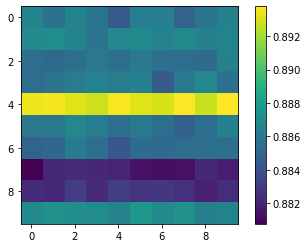

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(simmat_t_w)
plt.colorbar()
plt.show()